In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import torch 
import torchvision
from PIL import Image
import json
import datetime
from torchvision.transforms import transforms 
from torchvision.utils import make_grid
import torch.nn as nn
import time
import os
import copy
import torchvision.models as models
from torchvision.utils import save_image
import torch.nn.functional as F

from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

/var/folders/6r/r5dfhtxd75g2p4pkybxl8jcc0000gn/T/ipykernel_55466/1205883626.py:26: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


In [2]:
# local data_dir 
# data_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNet"
data_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/"
model_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/saved_models_2.0/"
# train/val/test dir CHANGE TO 64 or 255
data_file_path = data_dir + "/preprocessed_data/train_64_noreroofs.npy"
test_data_file_path = data_dir + "/preprocessed_data/test_64_noreroofs.npy"
val_data_file_path = data_dir + "/preprocessed_data/val_64_noreroofs.npy"

In [3]:
import sys
sys.path.append("/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/roofnet/utils")
from data import ImageDataset

In [4]:
# import Roofnet
# from Roofnet.utils.data import ImageDataset
from torchvision.transforms import transforms 


transform_chain = transforms.Compose([
                        transforms.ToPILImage(mode='RGB'),
                        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0),
                        transforms.ToTensor(),
                        transforms.Normalize([0.,0.,0,], [1.,1.,1.]),   
                        
                            ])
data = ImageDataset(data_file_path,
                    transform=transform_chain)
dataloader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True)
len(data), len(dataloader)


Loading data
Done loading data
Length 1050
Num Roofs 150


(1050, 33)

In [5]:
sample = data[0]  # get a sample from the dataset
print(type(sample))
print(len(sample))  # check the length of the tuple
print(sample[0])  # check the shape of the image tensor

<class 'tuple'>
3
tensor([[[0.6157, 0.5686, 0.5373,  ..., 0.1529, 0.2784, 0.3725],
         [0.6706, 0.6745, 0.6392,  ..., 0.1647, 0.1608, 0.3490],
         [0.6392, 0.6745, 0.6706,  ..., 0.1804, 0.1922, 0.2471],
         ...,
         [0.1216, 0.1176, 0.1216,  ..., 0.2078, 0.3098, 0.3216],
         [0.2431, 0.2824, 0.2627,  ..., 0.2471, 0.3059, 0.3216],
         [0.6314, 0.6314, 0.6118,  ..., 0.2235, 0.2275, 0.1843]],

        [[0.6275, 0.5804, 0.5608,  ..., 0.1451, 0.2745, 0.3843],
         [0.6863, 0.6941, 0.6549,  ..., 0.1451, 0.1451, 0.3529],
         [0.6510, 0.6902, 0.6706,  ..., 0.1569, 0.1647, 0.2353],
         ...,
         [0.1216, 0.1216, 0.1294,  ..., 0.2039, 0.3059, 0.3137],
         [0.2431, 0.2824, 0.2745,  ..., 0.2471, 0.2941, 0.3098],
         [0.6392, 0.6353, 0.6118,  ..., 0.2196, 0.2196, 0.1804]],

        [[0.6157, 0.5686, 0.5373,  ..., 0.1373, 0.2510, 0.3451],
         [0.6706, 0.6745, 0.6353,  ..., 0.1451, 0.1333, 0.3098],
         [0.6275, 0.6667, 0.6549,  ..., 

In [6]:
# Fixed input for debugging
fixed_x = next(iter(dataloader))
fixed_x = fixed_x[0]
print(fixed_x.shape)
# torch.Size([32, 3, 255, 255]) or torch.Size([32, 3, 64, 64])

torch.Size([32, 3, 64, 64])


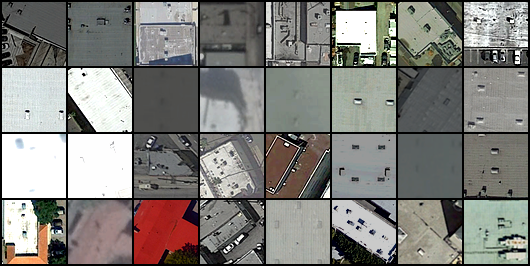

In [7]:
# can be skipped?
# Check to see if data is loaded 
save_image(fixed_x, 'real_image.png')

Image('real_image.png')

In [8]:
# Set default parameters
image_channels = fixed_x.size(1)

img_dim = fixed_x.size(-1)
print(img_dim)

64


In [9]:
from torch import device

def loss_fn(recon_x, x, mu, logvar,beta=1.0):
    x = x.to(device)
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    KLD*=beta
    return BCE + KLD, BCE, KLD

In [10]:
sys.path.append("/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/roofnet/models")
from vae import VAE


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VAE(img_dim = img_dim, image_channels=image_channels, z_dim=128,device=device).to(device)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

In [13]:
model = VAE(img_dim=64,image_channels=image_channels,z_dim=128,device=device).to(device)
model.load_state_dict(torch.load('/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/saved_models_2.0/roofnet_VAE_64_1.pth'))
model.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU()
    (8): Flatten()
  )
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(32, 3, kernel_size=(6, 6), stride=(2, 2))
    (8): Sigmoid()
  )
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1024, bias=True)
)

# Compare real image and reconstruction

Note: VAEs are known to generate blurry. The reason is that the latent code is trying to compress as much info as possible and only focus on the meaningful features.

In [14]:
#64x64
sys.path.append("/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/roofnet/models")
from vae import VAE

# change to the name of the model you want to load
model = VAE(img_dim=64,image_channels=image_channels,z_dim=128,device=device).to(device)
model.load_state_dict(torch.load(model_dir + '/roofnet_VAE_64_1.pth'))
val_data_file_path = data_dir + "preprocessed_data/val_64_noreroofs.npy"

In [15]:
# compare original and reconstructed images
def compare(x):
    x=x.to(device)
    recon_x,_, _, _ = model(x)
    return torch.cat([x, recon_x])

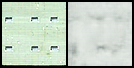

In [16]:
fixed_x = next(iter(dataloader))[0][:1]
compare_x = compare(fixed_x)

save_image(compare_x.data.cpu(), 'sample_image.png')
display(Image('sample_image.png', width=700, unconfined=True))

# Use validation data to make predicitons

In [17]:
transform_chain = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize([0.,0.,0,], [1.,1.,1.]),   
                        
                            ])
val_data = ImageDataset(val_data_file_path,
                    transform=transform_chain)

Loading data
Done loading data
Length 175
Num Roofs 25


In [18]:
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=7, shuffle=False)
val_dataloader = iter(val_dataloader)

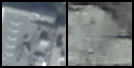

In [19]:
fixed_x = next(iter(val_dataloader))[0][:1]
compare_x = compare(fixed_x)

save_image(compare_x.data.cpu(), 'sample_image.png')
display(Image('sample_image.png', width=700, unconfined=True))

In [20]:
out = []
latents = []
meta = []
for i in val_dataloader:
    images = i[0]
    recon_images,z, _, _ = model(images.to(device))
    z = z.detach().cpu().numpy()
    latents.append(z)
    meta.append([i[2]['address'][0],int(i[2]['transition_year'][0].cpu().numpy())])
    d = int(np.argmax([np.linalg.norm(zi-zj) for zi,zj in zip(z[1:],z[:-1])]))+2013
    out.append([i[2]['address'][0],d,int(i[2]['transition_year'][0].cpu().numpy())])
out = np.array(out)
latents = np.array(latents)

In [21]:
hold = 0
l = 0
for i in out:
    if i[2] != 0:
        l += 1
        if i[1]==i[2]:
            hold += 1
print(hold/l)

0.3333333333333333


# Build binary classifier on latents

In [22]:
from torch.autograd import Variable

## Helper functions:

In [23]:
# Inputs: latent image 1, latent image 2, classification model, and prob threshold
# Returns binary classification, 1 for reroof, 0 for none.
# classifying two images as reroof if the probability is greater than the threshold

def classify_image_pair(latent_1,latent_2,model,prob_threshold=0.5):    # model is the classification model
    v_1 = np.hstack((latent_1,latent_2)) # concatenate the two latent vectors
    v_2 = np.hstack((latent_2,latent_1)) # concatenate the two latent vectors
    model.eval()
    p_1 = net(torch.tensor(v_1).to(device)) # pass the concatenated latent vectors to the classification model
    p_2 = net(torch.tensor(v_2).to(device)) # pass the concatenated latent vectors to the classification model
    prob = max([p_1.item(),p_2.item()]) # take the max probability
    return prob >= prob_threshold # return 1 if the probability is greater than the threshold, 0 otherwise

In [24]:
# Input: Latents for a building, meta for building, model, and threshold
# Output: [Address, predicted_transition, actual_transition]
# Returns transition year based on first transition detected
# If no transition detected, returns 0
def gen_predictions(latents,meta,model,prob_threshold=0.5): 
    out = [] 
    for i in range(len(latents)): # for each building
        hold = [] # hold the address, predicted transition year, and actual transition year
        hold.append(str(meta[i][0])) # append the address
        trans_year = 0 # initialize the transition year
        for j in range(len(latents[i])-1): # for each pair of latent vectors
            if classify_image_pair(latents[i][j],latents[i][j+1],model,prob_threshold=prob_threshold): # if the pair is classified as a reroof
                trans_year = j + 2013   # set the transition year to the year of the pair
                break
        hold.append(trans_year)  # append the transition year
        hold.append(int(meta[i][1])) # append the actual transition year
        out.append(hold) # append the list to the output
    return np.array(out) # return the output as an array

In [25]:
# Input: Latents for a building, meta for building, model, and threshold
# Output: [Address, predicted_transition, actual_transition]
# Returns transition year based on highest probability
# If no transition detected, returns 0
def get_max_prob(latents,meta,model,prob_threshold=0.5): 
    out = []
    for i in range(len(latents)): # for each building
        hold = []  # hold the address, predicted transition year, and actual transition year
        hold.append(str(meta[i][0]))   # append the address
        trans_year = 0
        temp = [] # hold the probabilities
        for j in range(len(latents[i])-1): # for each pair of latent vectors
            latent_1 = latents[i][j] # get the latent vectors
            latent_2 = latents[i][j+1] # get the latent vectors
            v_1 = np.hstack((latent_1,latent_2)) # concatenate the latent vectors
            v_2 = np.hstack((latent_2,latent_1)) # concatenate the latent vectors
            model.eval()
            p_1 = net(torch.tensor(v_1).to(device)) # pass the concatenated latent vectors to the classification model
            p_2 = net(torch.tensor(v_2).to(device)) # pass the concatenated latent vectors to the classification model
            prob = max([p_1.item(),p_2.item()]) # take the max probability
            temp.append(prob) # append the probability
        index = np.argmax(temp)     # get the index of the max probability
        if temp[index]>=prob_threshold: # if the max probability is greater than the threshold
            trans_year = 2013 + index # set the transition year to the year of the max probability 
        hold.append(trans_year) # append the transition year
        hold.append(int(meta[i][1]))       # append the actual transition year
        out.append(hold)    # append the list to the output
    return np.array(out)    # return the output as an array

In [26]:
# Generates accuracy metrics for detecting reroof and predicting reroof date
# No reroof is defined as a building that has no reroof in the dataset
# Reroof is defined as a building that has a reroof in the dataset
def gen_metrics(acc_metric, latents, meta, model, threshold=0.5):   
    no_reroof_pred = [] # hold the predictions for buildings with no reroof
    reroof_pred = [] # hold the predictions for buildings with a reroof
    hold = acc_metric(latents,meta, net ,threshold) # get the predictions
    print("Overall accuracy: {:0.3f}".format(np.mean(hold[:,1]==hold[:,2]))) # print the overall accuracy
    for i in hold: # for each building
        if int(i[2])==0:    # if the building has no reroof
            no_reroof_pred.append(int(int(i[1]) == 0))      # append the prediction
        else:
            reroof_pred.append(int(i[1]==i[2]))         # append the prediction
    print("No reroof prediction accuracy: {:0.3f}".format(np.mean(no_reroof_pred)))
    print("Reroof prediction accuracy: {:0.3f}".format(np.mean(reroof_pred)))
    return hold

In [27]:
# Inputs: file path for data
# Outputs: Dataloader for training

def gen_dataloader(data_file_path):     
    transform_chain = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize([0.,0.,0,], [1.,1.,1.]),   
                        
                            ])
    data = ImageDataset(data_file_path,
                        transform=transform_chain)

    dataloader = torch.utils.data.DataLoader(data, batch_size=7, shuffle=False)
    dataloader = iter(dataloader)
    return dataloader

In [28]:
# Input: dataloader, latent generating model
# Outputs: Latents generate by model, meta data for buildings
# Generates latents for all buildings in dataloader

def gen_latents(dataloader, model): # generate latents for all buildings in dataloader
    latents = [] # hold the latents for the buildings
    meta = [] # hold the meta data for the buildings
    for i in dataloader: # for each building
        images = i[0] # get the images
        _, z, _, _ = model(images.to(
            
        )) # get the latents
        z = z.detach().cpu().numpy()    # detach the latents in order to append to list
        latents.append(z)  # append the latents
        meta.append([i[2]['address'][0],int(i[2]['transition_year'][0].cpu().numpy())])     # append the meta data
    latents = np.array(latents)     # convert the latents to an array
    return latents, meta    

In [29]:
# Inputs: Latents of data, meta for building
# Output: All possible pairs of latent images and their label 1:reroof, 0:no reroof
# Generates all possible pairs of latent images and their label 1:reroof, 0:no reroof
# Used for training binary classifier

def gen_binary_data(latents, meta):         # generate all possible pairs of latent images and their label 1:reroof, 0:no reroof
    data_hold = []  # hold the latent pairs
    label_hold = []     # hold the labels
    for i in range(len(latents)):   # for each building
        for j in range(len(latents[i])):    # for each latent vector
            for k in range(len(latents[i])):        # for each latent vector
                data_hold.append(np.hstack((latents[i][j],latents[i][k])))      # append the latent pair
                year_j = 2012+j < meta[i][1]        # get the year of the latent vector
                year_k = 2012+k < meta[i][1]        # get the year of the latent vector
                label_hold.append(float(year_j != year_k))    # append the label
    data_hold = np.array(data_hold)     # convert the data to an array
    label_hold = np.array(label_hold)   # convery the labels to an array
    
    return data_hold, label_hold

## Load the data

In [30]:
# z_dim = 128 is the dimension of the latent space
model = VAE(img_dim=64,image_channels=image_channels,z_dim=128,device=device).to(device)
model.load_state_dict(torch.load(model_dir + 'roofnet_VAE_64_1.pth'))
data_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/"
data_file_path = data_dir + "preprocessed_data/train_64_noreroofs.npy" 

binary_dataloader = gen_dataloader(data_file_path)

Loading data
Done loading data
Length 1050
Num Roofs 150


In [31]:
val_data_file_path = data_dir + "preprocessed_data/val_64_noreroofs.npy"

binary_val_dataloader = gen_dataloader(val_data_file_path)

Loading data
Done loading data
Length 175
Num Roofs 25


In [32]:
test_data_file_path = data_dir + "/preprocessed_data/test_64_noreroofs.npy"

binary_test_dataloader = gen_dataloader(test_data_file_path)

Loading data
Done loading data
Length 385
Num Roofs 55


In [33]:
latents, meta = gen_latents(binary_dataloader, model)
print(latents.shape)

(150, 7, 128)


In [34]:
val_latents, val_meta = gen_latents(binary_val_dataloader, model)
print(val_latents.shape)

(25, 7, 128)


In [35]:
test_latents, test_meta = gen_latents(binary_test_dataloader, model)

In [36]:
data_hold, label_hold = gen_binary_data(latents, meta)

print(data_hold.shape)
print(data_hold)
print(label_hold.shape)

(7350, 256)
[[ 0.1163744   0.93102264  0.02152691 ... -0.2278043   0.7820316
   0.14587776]
 [ 0.1163744   0.93102264  0.02152691 ... -0.27390987  0.6458302
   0.17557462]
 [ 0.1163744   0.93102264  0.02152691 ... -0.31761533  0.8667831
   0.18105632]
 ...
 [ 0.39205137  0.18432115 -0.51126933 ... -0.12692237 -1.8158709
   0.63772184]
 [ 0.39205137  0.18432115 -0.51126933 ... -0.08791256 -1.3417883
   0.577735  ]
 [ 0.39205137  0.18432115 -0.51126933 ... -0.11414186 -1.4871984
   0.6467164 ]]
(7350,)


In [37]:
val_hold, val_label = gen_binary_data(val_latents, val_meta)
print(val_hold.shape)

(1225, 256)


In [38]:
test_hold, test_label = gen_binary_data(test_latents, test_meta)
print(test_hold.shape)
print(test_hold)


(2695, 256)
[[ 0.4655451   0.70860785 -0.4490634  ... -0.42794126 -0.45441967
   0.33098534]
 [ 0.4655451   0.70860785 -0.4490634  ...  0.25874677 -0.19022849
  -0.08955541]
 [ 0.4655451   0.70860785 -0.4490634  ... -0.39013904 -0.299292
   0.3053531 ]
 ...
 [-0.19419274  0.10126185  0.07276237 ...  0.09959272  0.07841878
  -0.06824647]
 [-0.19419274  0.10126185  0.07276237 ...  0.04344717  0.02014275
  -0.07638614]
 [-0.19419274  0.10126185  0.07276237 ...  0.00853089  0.05225223
  -0.16008803]]


In [39]:
# to check the number of reroofs and no reroofs in the dataset
# it is because we have 7 images for builidings and if there is a reroof, the count of reroofs will be smaller
reroof_count = np.sum(test_label == 1)
no_reroof_count = np.sum(test_label == 0)

print(f"Reroof count: {reroof_count}")
print(f"No Reroof count: {no_reroof_count}")


Reroof count: 512
No Reroof count: 2183


# Training Phase

## Binary SotA Model

In [49]:
# train_epoch for binary classifier

def binary_train_epoch(model, opt, criterion, data, labels, data_loader, val_data, val_labels, val_data_loader, best_acc, logit=False):
    
    best_model_wts = copy.deepcopy(model.state_dict()) # save best model weights
    
    model.train() # set model to training mode
    loss_hold = [] # hold loss for each batch
    
    for i in iter(data_loader): # iterate through batches
        batch_size = len(i)   # get batch size
        x_batch = data[i]   # get batch data 
        y_batch = labels[i]    # get batch labels
        
        x_batch = Variable(torch.from_numpy(x_batch)) # convert to torch variable
        y_batch = torch.tensor(y_batch, dtype=torch.float, device=device)       # convert to torch variable
        y_batch = y_batch.view(batch_size,-1)       # reshape to batch size
        
        opt.zero_grad()         # zero the parameter gradients
        y_hat = model(x_batch.to(model.device))         # forward pass, after the data is on the correct device, it is passed through the model
        loss = criterion(y_hat,y_batch)     # calculate loss 
        loss.backward()         # backward pass
        opt.step()          # update parameters
        
        loss_hold.append(loss.item()/batch_size)            # append loss
    print("Epoch training loss:{:.3f}".format(np.mean(loss_hold)))   # print epoch loss
    
    #validate  

    model.eval()
    pred_acc = [] # hold prediction accuracy for each batch
    for i in iter(val_data_loader):     # iterate through batches
        batch_size = len(i)     # get batch size
        x_batch = val_data[i]       # get batch data
        y_batch = val_labels[i]     # get batch labels
        
        x_batch = Variable(torch.from_numpy(x_batch))   # convert to torch variable
        
        if logit:   # if logit, use sigmoid
            y_logits = model(x_batch.to(model.device))       # forward pass
            s = nn.Sigmoid()    # sigmoid function
            y_hat = s(y_logits) > 0.5     # get prediction
        else:
            y_hat = model(x_batch.to(model.device))>0.5     # forward pass, get prediction
        
        pred_acc.append(np.mean(y_hat.cpu().numpy() == y_batch.reshape(batch_size,-1))) # append prediction accuracy
        
    pred_acc = np.mean(pred_acc)    # get epoch prediction accuracy
    print("Epoch validation accuracy: {:.3f}%".format(pred_acc))        # print epoch prediction accuracy
    
    if pred_acc >= best_acc:        # if epoch prediction accuracy is better than best prediction accuracy
        best_model_wts = copy.deepcopy(model.state_dict()) # save best model weights
        best_acc = pred_acc     # update best prediction accuracy
    
    net.load_state_dict(best_model_wts)     # load best model weights
    
    return net, best_acc 
        
        

In [50]:
class Net(nn.Module): # binary classifier
    
    def __init__(self, zdim = 128): # initialize network # zdim is the dimension of the latent vector
        super().__init__()  # inherit from nn.Module
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    # get device
        
        self.network = nn.Sequential( # define network
            nn.Linear(2*zdim, 2*zdim), # input layer
            nn.ReLU(),  # activation function
            nn.Dropout(0.2),    # dropout
            nn.Linear(2*zdim, zdim),   # hidden layer
            nn.ReLU(), # activation function
            nn.Dropout(0.2),   # dropout
            nn.Linear(zdim, 64),    # hidden layer
            nn.ReLU(),  # activation function
            nn.Dropout(0.2),    # dropout
            nn.Linear(64, 1),   # output layer
            nn.Sigmoid()    # sigmoid function
        ).to(self.device)       # send network to device
              
    
    def forward(self, x):
        y = self.network(x)    # forward pass
        return y   # return output of network (prediction)
    
net = Net()    
opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss()    # binary cross entropy loss



In [51]:
def save_model(model, run, epoch, folder='binary_classifier_sota_10'):
    if not os.path.exists(folder):
        os.makedirs(folder)  # Create the folder if it doesn't exist
    filename = f'model_run_sota{run + 1}.pth'
    torch.save(model.state_dict(), os.path.join(folder, filename))

In [52]:
index_loader = torch.utils.data.DataLoader(np.arange(len(data_hold)),batch_size=32,shuffle=True) # index loader is used to shuffle the data
val_index_loader = torch.utils.data.DataLoader(np.arange(len(val_hold)),batch_size=32,shuffle=True)

In [53]:
NUM_TRAININGS = 10
num_epochs = 10

for training in range(NUM_TRAININGS):
    print(f"Training run: {training + 1}/{NUM_TRAININGS}")

    # Reinitialize the network and optimizer for each training run
    net = Net()    
    opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
    
    best_acc = 0

    for e in range(num_epochs):
        print('Running epoch {}/{}'.format(e+1, num_epochs))
        net, best_acc = binary_train_epoch(net, opt, criterion, data_hold, label_hold, index_loader, val_hold, val_label, val_index_loader, best_acc)
        
    # Save model after each training
    save_model(net, training, e)


Training run: 1/10
Running epoch 1/10
Epoch training loss:0.014
Epoch validation accuracy: 0.895%
Running epoch 2/10
Epoch training loss:0.009
Epoch validation accuracy: 0.894%
Running epoch 3/10
Epoch training loss:0.008
Epoch validation accuracy: 0.913%
Running epoch 4/10
Epoch training loss:0.007
Epoch validation accuracy: 0.909%
Running epoch 5/10
Epoch training loss:0.007
Epoch validation accuracy: 0.906%
Running epoch 6/10
Epoch training loss:0.007
Epoch validation accuracy: 0.912%
Running epoch 7/10
Epoch training loss:0.007
Epoch validation accuracy: 0.873%
Running epoch 8/10
Epoch training loss:0.007
Epoch validation accuracy: 0.905%
Running epoch 9/10
Epoch training loss:0.007
Epoch validation accuracy: 0.906%
Running epoch 10/10
Epoch training loss:0.007
Epoch validation accuracy: 0.905%
Training run: 2/10
Running epoch 1/10
Epoch training loss:0.014
Epoch validation accuracy: 0.876%
Running epoch 2/10
Epoch training loss:0.008
Epoch validation accuracy: 0.903%
Running epoch

## Assesing SHAP values

What is a representative background?
https://openreview.net/pdf?id=L38bbHmRKx

In [122]:
import numpy as np
import shap

# Assuming you have your data and model ready
data_train = data_hold
model = Net()

# Initialize the variables
background_sizes = [100, 500, 1000]
num_simulations = 5
num_features = 256  # As you mentioned
num_instances = data_train.shape[0]
variances = np.zeros((num_instances, num_features, len(background_sizes)))

for idx_size, size in enumerate(background_sizes):
    for simulation in range(num_simulations):
        # Sample 'size' instances from training data as the background
        indices = np.random.choice(len(data_train), size, replace=False)
        background_data_np = data_train[indices]

        # Convert numpy array to PyTorch tensor for background
        background_data = torch.tensor(background_data_np, dtype=torch.float32)

        # Convert numpy array to PyTorch tensor for data_train
        data_train_tensor = torch.tensor(data_train, dtype=torch.float32)

        # Compute SHAP values
        explainer = shap.DeepExplainer(model, background_data)
        shap_values = explainer.shap_values(data_train_tensor)
        all_shap_values[simulation, :, :] = shap_values[0]

    # Calculate variance for each instance and feature
    for instance_idx in range(num_instances):
        for feature_idx in range(num_features):
            feature_values = all_shap_values[:, instance_idx, feature_idx]
            mean_value = np.mean(feature_values)
            variance = np.mean((feature_values - mean_value)**2)
            variances[instance_idx, feature_idx, idx_size] = variance

# 'variances' now has the variance of SHAP values for each feature, for each instance, across different background sizes

# Create a dataframe
df_list = []

for instance_idx in range(num_instances):
    for feature_idx in range(num_features):
        row = {
            'Instance': instance_idx,
            'Feature': feature_idx,
            'Variance (m=100)': variances[instance_idx, feature_idx, 0],
            'Variance (m=500)': variances[instance_idx, feature_idx, 1],
            'Variance (m=1000)': variances[instance_idx, feature_idx, 2],
        }
        df_list.append(row)

df = pd.DataFrame(df_list)

# To display the table
print(df)

# Optionally, save the dataframe to a CSV for further inspection
df.to_csv('shap_variance_table.csv', index=False)


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


         Instance  Feature  Variance (m=100)  Variance (m=500)  \
0               0        0      9.203799e-10      1.955645e-10   
1               0        1      5.028307e-10      7.555099e-11   
2               0        2      1.212459e-10      8.267046e-11   
3               0        3      2.185456e-10      1.014971e-10   
4               0        4      8.450093e-10      9.980854e-11   
...           ...      ...               ...               ...   
1881595      7349      251      3.900709e-11      4.670210e-11   
1881596      7349      252      1.129864e-10      1.289363e-11   
1881597      7349      253      6.779367e-10      2.003543e-10   
1881598      7349      254      9.580141e-10      1.057775e-10   
1881599      7349      255      5.767443e-10      1.375815e-10   

         Variance (m=1000)  
0             3.293432e-11  
1             1.500154e-10  
2             3.280168e-11  
3             4.483093e-11  
4             1.837879e-11  
...                    ...  
1881

In [123]:
df.head()

,Instance,Feature,Variance (m=100),Variance (m=500),Variance (m=1000)
0,0,0,9.203799e-10,1.955645e-10,3.293432e-11
1,0,1,5.028307e-10,7.555099e-11,1.500154e-10
2,0,2,1.212459e-10,8.267046e-11,3.280168e-11
3,0,3,2.185456e-10,1.014971e-10,4.483093e-11
4,0,4,8.450093e-10,9.980854e-11,1.837879e-11


In [124]:

# Calculate sum for each variance column
sum_100 = df['Variance (m=100)'].sum()
sum_500 = df['Variance (m=500)'].sum()
sum_1000 = df['Variance (m=1000)'].sum()

print(f'Sum of Variance (m=100): {sum_100}')
print(f'Sum of Variance (m=500): {sum_500}')
print(f'Sum of Variance (m=1000): {sum_1000}')

Sum of Variance (m=100): 0.0022659337557297305
Sum of Variance (m=500): 0.0003412888175928505
Sum of Variance (m=1000): 0.00014983675297343955


What are "good" SHAP values?

https://www.mdpi.com/2076-3417/12/13/6681  representative shap values

In [40]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
import shap
import copy
import numpy as np
from sklearn.model_selection import KFold


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [41]:
class Net(nn.Module): # binary classifier
    
    def __init__(self, zdim = 128): # initialize network # zdim is the dimension of the latent vector
        super().__init__()  # inherit from nn.Module
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    # get device
        
        self.network = nn.Sequential( # define network
            nn.Linear(2*zdim, 2*zdim), # input layer
            nn.ReLU(),  # activation function
            nn.Dropout(0.2),    # dropout
            nn.Linear(2*zdim, zdim),   # hidden layer
            nn.ReLU(), # activation function
            nn.Dropout(0.2),   # dropout
            nn.Linear(zdim, 64),    # hidden layer
            nn.ReLU(),  # activation function
            nn.Dropout(0.2),    # dropout
            nn.Linear(64, 1),   # output layer
            nn.Sigmoid()    # sigmoid function
        ).to(self.device)       # send network to device
              
    
    def forward(self, x):
        y = self.network(x)    # forward pass
        return y   # return output of network (prediction)
    
net = Net()    
opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss()    # binary cross entropy loss



In [42]:
index_loader = torch.utils.data.DataLoader(np.arange(len(data_hold)),batch_size=32,shuffle=True) # index loader is used to shuffle the data
val_index_loader = torch.utils.data.DataLoader(np.arange(len(val_hold)),batch_size=32,shuffle=True)

In [51]:
def binary_train_epoch(model, opt, criterion, data_loader, val_data_loader, best_acc, logit=False):
    
    best_model_wts = copy.deepcopy(model.state_dict()) # save best model weights
    
    model.train() # set model to training mode
    loss_hold = [] # hold loss for each batch
    
    for x_batch, y_batch in iter(data_loader): # iterate through batches
        batch_size = x_batch.size(0)   # get batch size
        
        x_batch = x_batch.to(device) # move to device
        y_batch = y_batch.float().view(batch_size, -1).to(device)
        
        opt.zero_grad()         # zero the parameter gradients
        y_hat = model(x_batch)         # forward pass
        loss = criterion(y_hat, y_batch)     # calculate loss 
        loss.backward()         # backward pass
        opt.step()          # update parameters
        
        loss_hold.append(loss.item()/batch_size)            # append loss
    print("Epoch training loss:{:.3f}".format(np.mean(loss_hold)))   # print epoch loss
    
    #validate
    model.eval()
    pred_acc = [] # hold prediction accuracy for each batch
    
    for x_batch, y_batch in iter(val_data_loader):     # iterate through batches
        batch_size = x_batch.size(0)     # get batch size
        
        x_batch = x_batch.to(device)
        
        if logit:   # if logit, use sigmoid
            y_logits = model(x_batch)       # forward pass
            s = nn.Sigmoid()    # sigmoid function
            y_hat = s(y_logits) > 0.5     # get prediction
        else:
            y_hat = model(x_batch) > 0.5     # forward pass, get prediction
        
        pred_acc.append(np.mean(y_hat.cpu().numpy() == y_batch.reshape(batch_size,-1))) # append prediction accuracy
        
    pred_acc = np.mean(pred_acc)    # get epoch prediction accuracy
    print("Epoch validation accuracy: {:.3f}%".format(pred_acc))        # print epoch prediction accuracy
    
    if pred_acc >= best_acc:        # if epoch prediction accuracy is better than best prediction accuracy
        best_model_wts = copy.deepcopy(model.state_dict()) # save best model weights
        best_acc = pred_acc     # update best prediction accuracy
    
    model.load_state_dict(best_model_wts)     # load best model weights
    
    return model, best_acc


In [54]:
import copy
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
import shap

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

R = 10  # Number of repetitions
K = 5  # Number of folds
NUM_EPOCHS = 10
BATCH_SIZE = 32
# Matrices to store SHAP values
train_folds_shap_values = torch.zeros((len(data_hold), 2*128))  # Assuming the feature dimension here
test_folds_shap_values = torch.zeros((len(data_hold), 2*128))

for r in range(R):
    print(f"Repetition {r+1}/{R}")
    
    kf = KFold(n_splits=K, shuffle=True, random_state=r)
    
    for train_index, test_index in kf.split(data_hold):
        X_train, X_test = data_hold[train_index], data_hold[test_index]
        y_train, y_test = label_hold[train_index], label_hold[test_index]
        
        # Convert to tensors
        train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
        val_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

        # Create data_loaders for the current fold
        train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_data_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

        # Randomly selecting 500 samples from the training data for the background
        background_indices = np.random.choice(len(X_train), size=500, replace=False)
        background = X_train[background_indices]

        # Reinitialize the model and optimizer for each fold
        net =  net.to(device)   
        opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
        best_acc = 0

        # Training for each fold
        for e in range(NUM_EPOCHS):
            net, best_acc = binary_train_epoch(net, opt, criterion, train_data_loader, val_data_loader, best_acc)

        # Convert background to a tensor and move it to the appropriate device
        background_tensor = torch.Tensor(background).to(device)

        # Compute SHAP values using Deep SHAP with the tensors
        e = shap.DeepExplainer(net, background_tensor)
        train_shap_values = e.shap_values(torch.Tensor(X_train).to(device))
        test_shap_values = e.shap_values(torch.Tensor(X_test).to(device))

        train_folds_shap_values[train_index] += torch.tensor(train_shap_values[0]).cpu()  # Convert to tensor and sum
        test_folds_shap_values[test_index] += torch.tensor(test_shap_values[0]).cpu()
        
# Averaging SHAP values over repetitions
average_train_folds_shap_values = train_folds_shap_values / R
average_test_folds_shap_values = test_folds_shap_values / R


Repetition 1/10
Epoch training loss:0.007
Epoch validation accuracy: 0.000%
Epoch training loss:0.010
Epoch validation accuracy: 0.000%
Epoch training loss:0.007
Epoch validation accuracy: 0.000%
Epoch training loss:0.007
Epoch validation accuracy: 0.000%
Epoch training loss:0.007
Epoch validation accuracy: 0.000%
Epoch training loss:0.006
Epoch validation accuracy: 0.000%
Epoch training loss:0.006
Epoch validation accuracy: 0.000%
Epoch training loss:0.006
Epoch validation accuracy: 0.000%
Epoch training loss:0.006
Epoch validation accuracy: 0.000%
Epoch training loss:0.005
Epoch validation accuracy: 0.000%
Epoch training loss:0.008
Epoch validation accuracy: 0.000%
Epoch training loss:0.010
Epoch validation accuracy: 0.000%
Epoch training loss:0.008
Epoch validation accuracy: 0.000%
Epoch training loss:0.008
Epoch validation accuracy: 0.000%
Epoch training loss:0.007
Epoch validation accuracy: 0.000%
Epoch training loss:0.007
Epoch validation accuracy: 0.000%
Epoch training loss:0.00

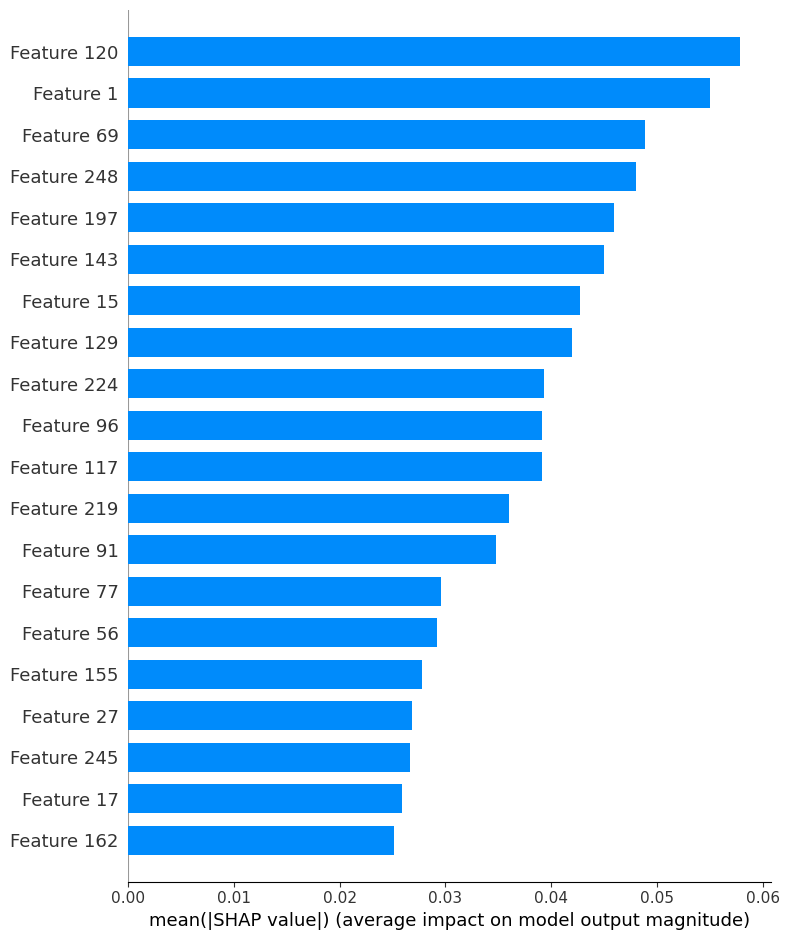

In [113]:
average_train_folds_shap_values_numpy = average_train_folds_shap_values.numpy()
shap.summary_plot(average_train_folds_shap_values_numpy, data_hold, plot_type="bar", show="False")


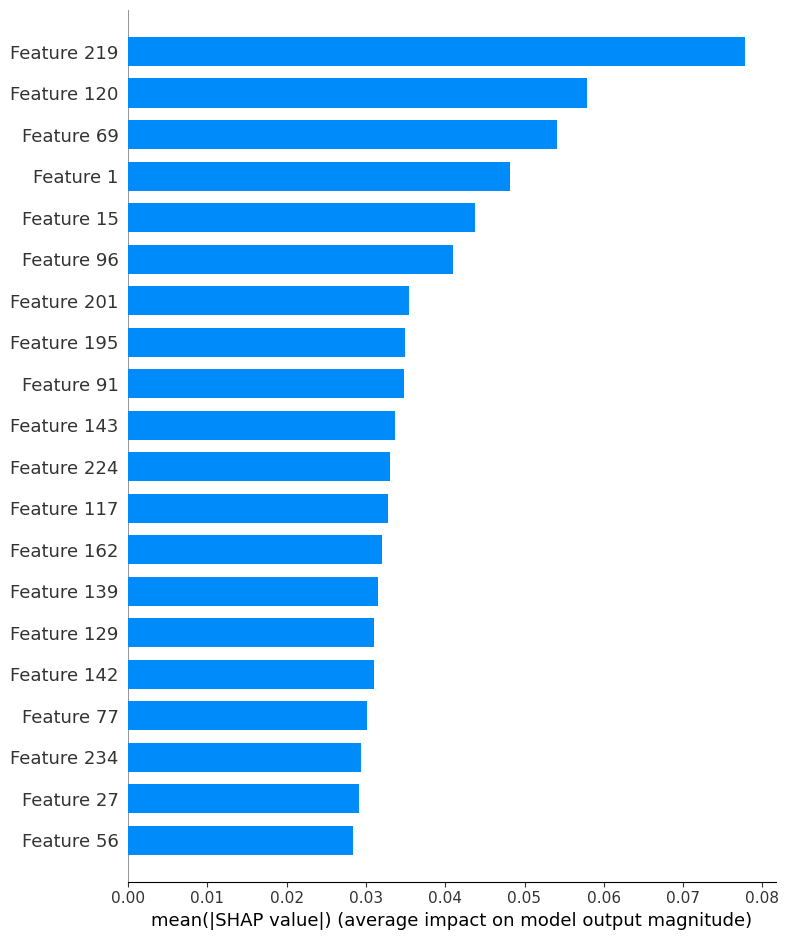

In [114]:
average_test_folds_shap_values_numpy = average_test_folds_shap_values.numpy()
shap.summary_plot(average_test_folds_shap_values_numpy, data_hold, plot_type="bar", show="False")
